In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2
import json
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split



# from multiprocessing import set_start_method
# set_start_method('spawn')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype_float = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
# device = torch.device('cpu')

In [3]:
# letters = [' ', 'A', 'I', 'U', 'E', 'O', 'N']
letters = ['A', 'I', 'U', 'E', 'O', 'N']

In [4]:
workdir = Path('/home/jphacks/LipNet-JP/')
youtube_id = '1'
# youtube_id = '2'
spk = 's{}'.format(youtube_id)
txtpath = workdir / 'data/align' / 'output{}word.align'.format(youtube_id)
aligned_lm_path = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned.csv'.format(youtube_id))
lm_path = Path('/home/jphacks/LipNet-JP/data/processed/{0}/{0}.csv'.format(youtube_id))
croppeddir = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned_aligned_cropped'.format(youtube_id))
assert croppeddir.exists()

datadir = Path('/home/jphacks/LipNet-JP/data')
videodir = datadir / 'lip_video'
txtdir = datadir / 'align_txt'

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print(trainset.data.shape)  # (data size, w, h, channels)
print(trainset.data.shape)  # (data size, w, h, channels)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(50000, 32, 32, 3)


In [6]:
img = cv2.imread(str(list(croppeddir.iterdir())[0]))

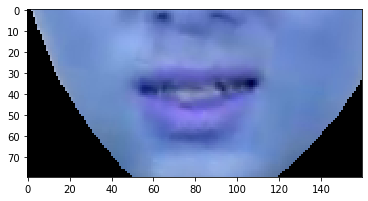

In [7]:
plt.imshow(img)

In [8]:
img.shape

(80, 160, 3)

## Model definition

In [28]:
inwidth, inheight = 160, 80
def conv_calc(wh: int):
    res = wh / 2 - 2
    if int(res) != res:
        raise Exception(str(res))
    return int(res)
convwidth, convheight = conv_calc(conv_calc(inwidth)), conv_calc(conv_calc(inheight))  # 17 x 37

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * convwidth * convheight, 6000)
        self.fc2 = nn.Linear(6000, 3000)
        self.fc3 = nn.Linear(3000, 1500)
        self.fc4 = nn.Linear(1500, 600)
        self.fc5 = nn.Linear(600, 120)
        self.fc6 = nn.Linear(120, 84)
        self.fc7 = nn.Linear(84, len(letters))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * convwidth * convheight)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

net = Net().to(device)

In [45]:
print(img.shape)
_in = torch.Tensor(img).permute(2, 0, 1).unsqueeze(0).to(device)
print(_in.shape)
output = net(_in)
output

(80, 160, 3)
torch.Size([1, 3, 80, 160])


RuntimeError: shape '[-1, 64, 28, 28]' is invalid for input of size 38400

In [11]:
aligned_lm_df = pd.read_csv(str(aligned_lm_path))
aligned_lm_df['timestamp'] = (aligned_lm_df['frame'] - 1) * (1/30)

with open(txtpath, 'r') as f:
    txt = json.load(f)

In [12]:
aligned_lm_df['target'] = -1

for word in txt:
    for c in word:
        aligned_lm_df.loc[(aligned_lm_df.timestamp >= c['start']) & (aligned_lm_df.timestamp < c['end']), 'target']         = letters.index(c['word'].upper())

# aligned_lm_df[aligned_lm_df.target >= 0]

In [13]:
aligned_lm_df.target.value_counts()

-1    3839
 0    1227
 4    1097
 1     894
 3     645
 5     575
 2     561
Name: target, dtype: int64

In [14]:
imglist = []
targetlist = []
_lett_counter = {l: 0 for l in letters}
for idx, row in aligned_lm_df.iterrows():
    if row.target < 0:
        continue
    imgpath = croppeddir / 'frame_det_00_{:06d}.bmp'.format(int(row.frame))
    img = cv2.imread(str(imgpath))
    if img.shape != (inheight, inwidth, 3):
        fixedsizeimg = np.zeros([inheight, inwidth, 3], dtype=np.uint8)
        s = img.shape
        fixedsizeimg[:s[0],:s[1],:s[2]] = img
        img = fixedsizeimg
    # img = np.moveaxis(img, 2, 0)  # (80, 160, 3) -> (3, 80, 160)
    imglist.append(img)
    targetlist.append(int(row.target))
    _lett_counter[letters[int(row.target)]] += 1

print(len(imglist), len(targetlist))
print(imglist[0].dtype)
print(_lett_counter)
# train_array_list, test_array_list = train_test_split(imgArray, test_size=.2)
# print(len(train_array_list), len(test_array_list))  # 3999 1000

# # https://stackoverflow.com/questions/27516849/how-to-convert-list-of-numpy-arrays-into-single-numpy-array
# # np.stackは結合する前に，shapeの0番目の前に1次元追加するので，この用途に適する．
# np.stack(imgArray).shape  # (8838, 80, 160, 3)

4999 4999
uint8
{'A': 1227, 'I': 894, 'U': 561, 'E': 645, 'O': 1097, 'N': 575}


In [15]:
train_idxlist, test_idxlist = train_test_split(list(range(len(imglist))), test_size=.2, shuffle=True)
print(len(train_idxlist), len(test_idxlist))

3999 1000


In [16]:
class LipDataset(Dataset):
    def __init__(self, imglist, targetlist, idxlist):
        self.imglist = imglist
        self.targetlist = targetlist
        self.idxlist = idxlist
    
    def __len__(self):
        return len(self.idxlist)
    
    def __getitem__(self, idx):
        return (self.imglist[self.idxlist[idx]], self.targetlist[self.idxlist[idx]])
    
    def _to_list(self):
        return [self[i] for i in range(len(self))]

train_lipdataset = LipDataset(imglist, targetlist, train_idxlist)
test_lipdataset = LipDataset(imglist, targetlist, test_idxlist)

In [17]:
train_lipdataset._to_list()

[(array([[[149, 178, 235],
          [150, 179, 236],
          [151, 180, 237],
          ...,
          [116, 141, 208],
          [117, 142, 208],
          [119, 146, 208]],
  
         [[147, 176, 233],
          [148, 177, 234],
          [150, 179, 236],
          ...,
          [115, 140, 207],
          [116, 142, 208],
          [117, 144, 206]],
  
         [[146, 175, 232],
          [147, 176, 233],
          [147, 176, 233],
          ...,
          [114, 140, 205],
          [116, 142, 206],
          [116, 143, 205]],
  
         ...,
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0

In [18]:
trainloader = torch.utils.data.DataLoader(train_lipdataset, batch_size=10,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_lipdataset, batch_size=1,
                                         shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [19]:
it = iter(trainloader)
next(it)

[tensor([[[[149, 178, 235],
           [150, 179, 236],
           [151, 180, 237],
           ...,
           [116, 141, 208],
           [117, 142, 208],
           [119, 146, 208]],
 
          [[147, 176, 233],
           [148, 177, 234],
           [150, 179, 236],
           ...,
           [115, 140, 207],
           [116, 142, 208],
           [117, 144, 206]],
 
          [[146, 175, 232],
           [147, 176, 233],
           [147, 176, 233],
           ...,
           [114, 140, 205],
           [116, 142, 206],
           [116, 143, 205]],
 
          ...,
 
          [[  0,   0,   0],
           [  0,   0,   0],
           [  0,   0,   0],
           ...,
           [  0,   0,   0],
           [  0,   0,   0],
           [  0,   0,   0]],
 
          [[  0,   0,   0],
           [  0,   0,   0],
           [  0,   0,   0],
           ...,
           [  0,   0,   0],
           [  0,   0,   0],
           [  0,   0,   0]],
 
          [[  0,   0,   0],
           [  0,   0

In [31]:
net.train()

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(2000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.permute(0, 3, 1, 2).type(dtype_float))
#         print(outputs[0], labels[0])
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / i))


print('Finished Training')

[1,   400] loss: 1.767
[2,   400] loss: 1.751
[3,   400] loss: 1.748
[4,   400] loss: 1.749
[5,   400] loss: 1.747
[6,   400] loss: 1.753
[7,   400] loss: 1.749
[8,   400] loss: 1.747
[9,   400] loss: 1.747
[10,   400] loss: 1.747
[11,   400] loss: 1.750
[12,   400] loss: 1.751
[13,   400] loss: 1.750
[14,   400] loss: 1.753
[15,   400] loss: 1.747
[16,   400] loss: 1.748
[17,   400] loss: 1.748
[18,   400] loss: 1.747
[19,   400] loss: 1.747
[20,   400] loss: 1.747
[21,   400] loss: 1.748
[22,   400] loss: 1.748
[23,   400] loss: 1.747
[24,   400] loss: 1.746
[25,   400] loss: 1.748
[26,   400] loss: 1.750
[27,   400] loss: 1.747
[28,   400] loss: 1.747
[29,   400] loss: 1.747
[30,   400] loss: 1.747


KeyboardInterrupt: 

In [1]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.permute(0, 3, 1, 2).type(dtype_float))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

NameError: name 'net' is not defined

In [24]:
net.eval()
class_correct = [0.] * len(letters)
class_total = [0.] * len(letters)
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images.permute(0, 3, 1, 2).type(dtype_float))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        class_correct[labels.item()] += c.item() * 1
        class_total[labels.item()] += 1


for i, l in enumerate(letters):
    print('Accuracy of    {}: {:.4f} ({:4d}/{:4d})'.format(l, class_correct[i]/class_total[i] if class_total[i] > 0 else 0, int(class_correct[i]), int(class_total[i])))

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
net.eval()
class_correct = [0.] * len(letters)
class_total = [0.] * len(letters)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.permute(0, 3, 1, 2).type(dtype_float))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        class_correct[labels.item()] += c.item() * 1
        class_total[labels.item()] += 1


for i, l in enumerate(letters):
    print('Accuracy of    {}: {:.4f} ({:4d}/{:4d})'.format(l, class_correct[i]/class_total[i] if class_total[i] > 0 else 0, int(class_correct[i]), int(class_total[i])))

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape, labels.shape)

In [ ]:
labels

# XGBoost

In [ ]:
import xgboost
from sklearn.metrics import accuracy_score

In [ ]:
lip_idexies = list(range(48, 68))
lip_x_list = [' x_{}'.format(i) for i in lip_idexies]
lip_y_list = [' y_{}'.format(i) for i in lip_idexies]

# x = aligned_lm_df[lip_x_list + lip_y_list].values
x = aligned_lm_df[(set(aligned_lm_df.columns) - {'targetflag'})].values
y = aligned_lm_df.targetflag.values

xgb = xgboost.XGBClassifier()

eval_result = {}
xgb.fit(x, y)

In [ ]:
accuracy_score(xgb.predict(x), y)

In [ ]:
pred = xgb.predict(x)

class_correct = [0] * len(letters)
class_total = [0] * len(letters)

for p, a in zip(pred, y):
    class_total[a] += 1
    if p == a:
        class_correct[a] += 1
        
for i, l in enumerate(letters):
    print('Accuracy of    {}: {:.4f} ({:4d}/{:4d})'.format(l, class_correct[i]/class_total[i], class_correct[i], class_total[i]))